In [2]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

In [3]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [140]:
# load the Cora dataset
dataset = 'Cora'
path = osp.join('../', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
print(dataset.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [141]:
# use train_test_split_edges to create neg and positive edges
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
print(data)

/opt/conda/envs/gnn/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])


In [84]:
from torch_geometric.data import DataLoader

In [24]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [25]:

model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [146]:
torch.cat([data.train_pos_edge_index , neg_edge_index],axis=-1)[0]

tensor([   0,    0,    0,  ..., 1707, 1329, 1394])

tensor([[1257,  831, 2279,  ..., 1707, 1329, 1394],
        [ 327,  635, 2639,  ..., 1571,  705,  499]])

In [68]:
neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges
z = model.encode(data.x , data.train_pos_edge_index) #encode
model.decode(z, data.train_pos_edge_index,neg_edge_index)

tensor([0.1496, 0.1951, 0.2067,  ..., 0.1592, 0.1683, 0.1628],
       grad_fn=<SumBackward1>)

In [139]:
(z[0] * z[1]).sum()

tensor(0.2035, grad_fn=<SumBackward0>)

In [101]:


def get_link_logits(model, x , edge_index , neg_edge_index) :
    z = model.encode(x , edge_index) #encode
    link_logits = model.decode(z, edge_index, neg_edge_index) # decode
    return link_logits


def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    link_logits = get_link_logits(model , data.x , data.train_pos_edge_index,neg_edge_index)
    optimizer.zero_grad()
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


#train()

In [147]:
neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

print(data.train_pos_edge_index.shape)
print(neg_edge_index.shape)
link_logits = get_link_logits(model , data.x , data.train_pos_edge_index,neg_edge_index)
print(link_logits.size())

torch.Size([2, 8976])
torch.Size([2, 8976])
torch.Size([17952])


In [44]:
link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
link_labels

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [43]:
link_logits.sigmoid()

tensor([0.5464, 0.5480, 0.5567,  ..., 0.5421, 0.5441, 0.5430],
       grad_fn=<SigmoidBackward0>)

In [35]:




@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']
        
        link_logits = get_link_logits(model , data.x , pos_edge_index,neg_edge_index)
        
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs


In [36]:
test()

[0.8742355679567435, 0.8816544185158914]

In [148]:
z = model.encode(data.x , data.train_pos_edge_index) #encode

In [149]:
z

tensor([[ 0.0201,  0.0546, -0.0176,  ...,  0.0309,  0.0406, -0.0440],
        [ 0.0334,  0.0447, -0.0274,  ...,  0.0341,  0.0288, -0.0455],
        [ 0.0330,  0.0489, -0.0212,  ...,  0.0332,  0.0361, -0.0441],
        ...,
        [ 0.0188,  0.0143,  0.0021,  ...,  0.0376,  0.0208, -0.0230],
        [ 0.0337,  0.0542, -0.0191,  ...,  0.0406,  0.0293, -0.0393],
        [ 0.0310,  0.0487, -0.0168,  ...,  0.0372,  0.0265, -0.0356]],
       grad_fn=<AddBackward0>)

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

In [163]:
dataset = Planetoid(path, "Cora", transform=T.NormalizeFeatures())
z = model.encode(dataset.data.x,dataset.data.edge_index) #encode

emb = TSNE(n_components=2, learning_rate='auto').fit_transform(z.detach().numpy())

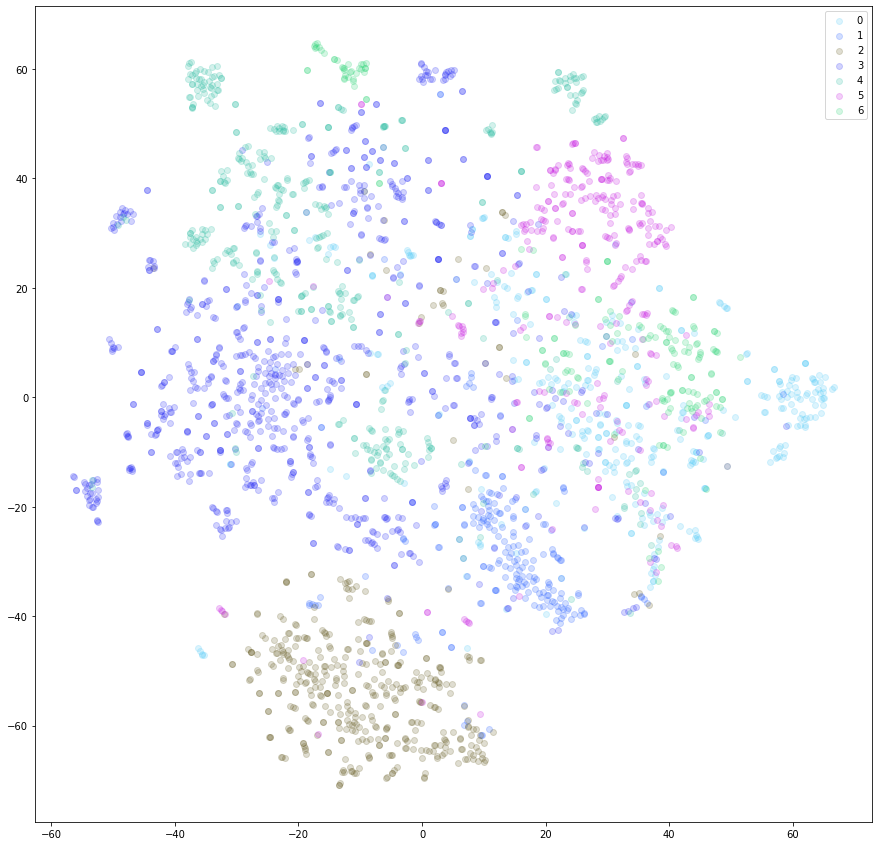

In [195]:

labels = dataset.data.y.detach().numpy()
fig, ax = plt.subplots(figsize=(15,15))

number_of_colors = len(np.unique(labels))

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
for idx , i in enumerate(np.unique(labels)) :
    emb_ = emb[np.where(labels == i ),:].squeeze()
    ax.scatter(x=emb_[:,0],y=emb_[:,1],c=color[idx], label=i,alpha=0.2)
else :
    ax.legend()
    plt.show()